# Sleep Behavior Analysis

This Jupyter notebook explores patterns in **synthetic sleep‑behavior data**. We examine how screen time, caffeine intake, daily steps, and room temperature relate to sleep duration and perceived sleep quality. Analyses include exploratory data analysis (EDA), visualizations, correlation inspection, and unsupervised clustering to identify user sleep profiles.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

## Load dataset

In [2]:
import os, sys, warnings
DATA_PATH = 'sleep_behavior.csv'
if not os.path.exists(DATA_PATH):
    warnings.warn('sleep_behavior.csv not found; generating synthetic data locally...')
    # --- quick synthetic data generator (same logic) ---
    n_days = 90
    start = pd.to_datetime('2025-03-31')
    rng = pd.date_range(start, periods=n_days, freq='D')
    np.random.seed(42)
    bed_mins = np.clip(np.random.normal(1410, 45, n_days), 1320, 1560).astype(int)
    wake_mins = np.clip(np.random.normal(465, 40, n_days), 360, 600).astype(int)
    dur = (wake_mins - bed_mins) % (24*60)
    scr = np.random.gamma(2.0, 15.0, n_days).clip(0, 120).astype(int)
    caffeine = np.random.choice([np.random.randint(0, 100), np.random.randint(100, 300), np.random.randint(300, 501)], n_days, p=[0.4, 0.45, 0.15])
    steps = np.random.gamma(4.5, 1500, n_days).clip(0, 20000).astype(int)
    temp = np.random.normal(23, 2.5, n_days).clip(18, 28).round(1)
    qual = np.where((scr>60)|(caffeine>300)|(steps<2500)|(dur<360),'poor', np.where((scr>30)|(caffeine>200)|(steps<5000)|(dur<420),'average','good'))
    def mins2str(arr): return [f'{(m//60)%24:02d}:{m%60:02d}' for m in arr]
    df = pd.DataFrame({'date': rng, 'bedtime': mins2str(bed_mins), 'wakeup_time': mins2str(wake_mins), 'sleep_duration_min': dur,
                       'screen_time_night_min': scr, 'caffeine_intake_mg': caffeine, 'steps': steps,
                       'room_temp_C': temp, 'sleep_quality': qual})
else:
    df = pd.read_csv(DATA_PATH, parse_dates=['date'])
df.head()

,date,bedtime,wakeup_time,sleep_duration_min,screen_time_night_min,caffeine_intake_mg,steps,room_temp_C,sleep_quality
0,2025-03-31,00:38,07:55,437,51,136,3172,18.7,average
1,2025-04-01,23:58,07:13,435,77,310,8494,19.9,poor
2,2025-04-02,23:50,08:47,537,25,22,8411,23.0,good
3,2025-04-03,23:44,07:01,437,23,431,5061,22.6,poor
4,2025-04-04,23:29,08:31,542,5,311,8740,23.6,poor


## Quick data overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   90 non-null     datetime64[ns]
 1   bedtime                90 non-null     object        
 2   wakeup_time            90 non-null     object        
 3   sleep_duration_min     90 non-null     int64         
 4   screen_time_night_min  90 non-null     int64         
 5   caffeine_intake_mg     90 non-null     int64         
 6   steps                  90 non-null     int64         
 7   room_temp_C            90 non-null     float64       
 8   sleep_quality          90 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 6.5+ KB


In [4]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,90,2025-05-14 12:00:00,2025-03-31 00:00:00,2025-04-22 06:00:00,2025-05-14 12:00:00,2025-06-05 18:00:00,2025-06-28 00:00:00,NaN
sleep_duration_min,90.0,494.277778,346.0,449.5,496.0,541.75,654.0,58.506703
screen_time_night_min,90.0,31.822222,0.0,16.0,29.0,46.5,80.0,19.250319
caffeine_intake_mg,90.0,152.677778,1.0,61.0,121.0,237.0,486.0,118.017027
steps,90.0,7169.588889,1212.0,4816.25,6836.0,9215.5,16995.0,3434.95966
room_temp_C,90.0,23.23,18.0,21.5,23.05,25.15,28.0,2.567404


## Sleep quality distribution

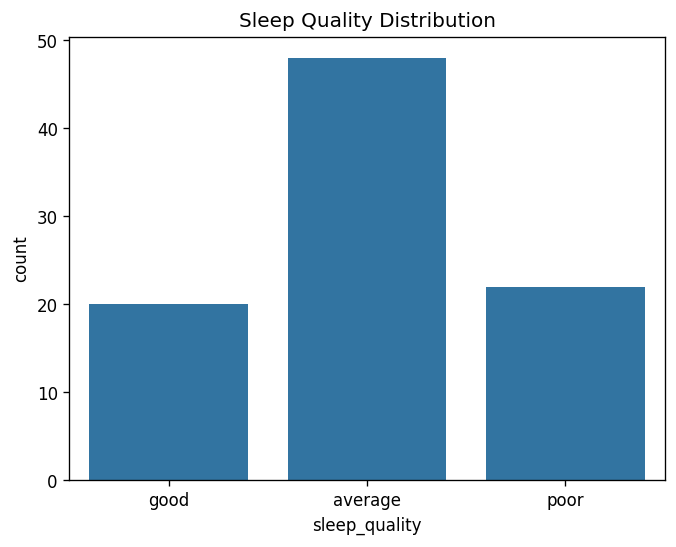

In [5]:
sns.countplot(x='sleep_quality', data=df, order=['good','average','poor'])
plt.title('Sleep Quality Distribution')
plt.show()

## Sleep duration vs quality

D:\Users\Ali\miniconda3\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


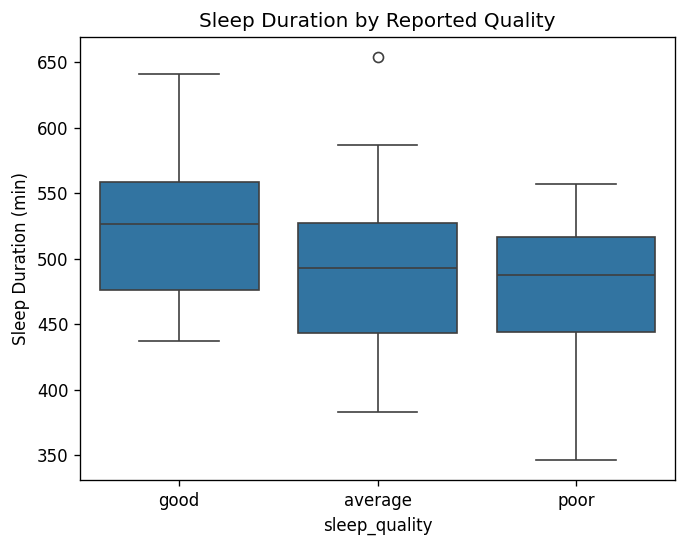

In [6]:
sns.boxplot(x='sleep_quality', y='sleep_duration_min', data=df, order=['good','average','poor'])
plt.ylabel('Sleep Duration (min)')
plt.title('Sleep Duration by Reported Quality')
plt.show()

## Screen time vs sleep duration

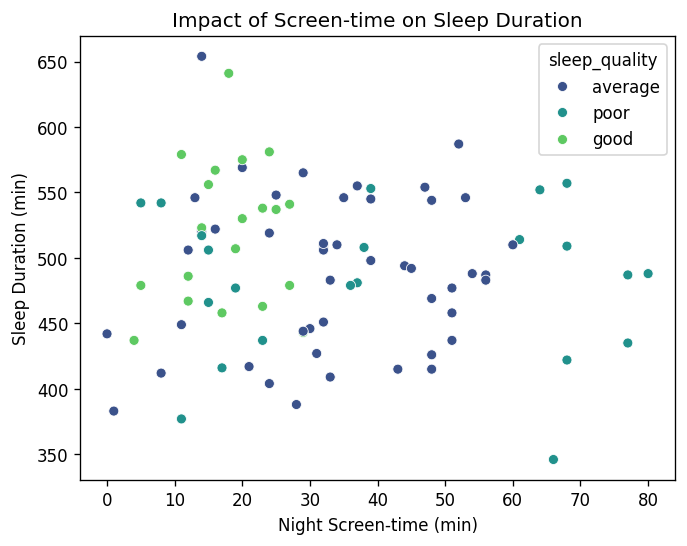

In [7]:
sns.scatterplot(x='screen_time_night_min', y='sleep_duration_min', hue='sleep_quality', data=df, palette='viridis')
plt.xlabel('Night Screen‑time (min)')
plt.ylabel('Sleep Duration (min)')
plt.title('Impact of Screen‑time on Sleep Duration')
plt.show()

## Correlation analysis

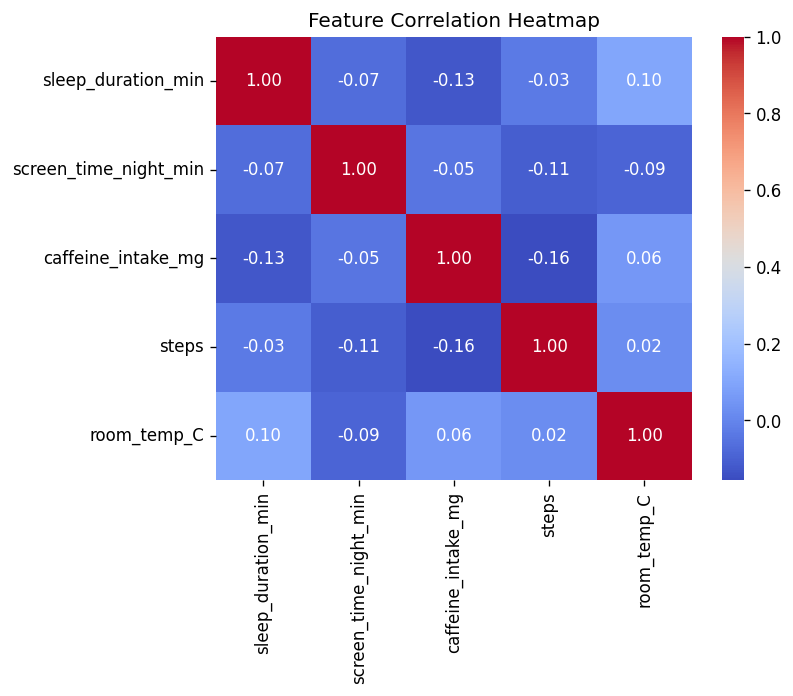

In [8]:
numeric_cols = ['sleep_duration_min','screen_time_night_min','caffeine_intake_mg','steps','room_temp_C']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Clustering sleep profiles

In [9]:
# Prepare data
X = df[numeric_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)
df['cluster'].value_counts()

cluster
1    38
0    31
2    21
Name: count, dtype: int64

D:\Users\Ali\miniconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Users\Ali\miniconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Users\Ali\miniconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


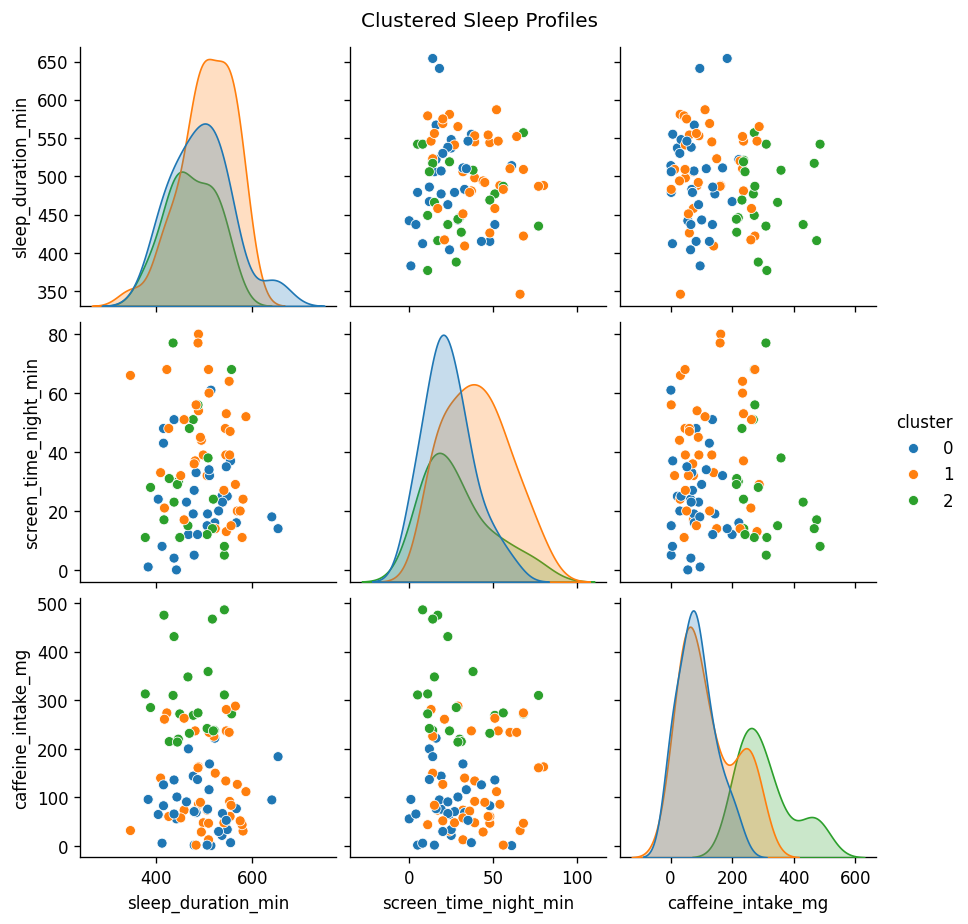

In [10]:
sns.pairplot(df, vars=['sleep_duration_min','screen_time_night_min','caffeine_intake_mg'], hue='cluster', palette='tab10')
plt.suptitle('Clustered Sleep Profiles', y=1.02)
plt.show()